# Violence in Mexico

This notebook is to shed some light on the violence in Mexico. We'll discuss which ones are the most violent states and the trend of violence. The notebook will consist on a general trends of murders. We'll investigate which are the most dominant types of murders.

## DISCLAIMER

I am not affiliated to any political party in Mexico. This is just doing a small side project to visualize the violence trends in Mexico. I don't support any politician, nor I want to spur any vitriol in the current or any past governments. I *do not* support anyone using any of the figures presented in this notebook to be used for or against any current or past members of government. **THIS IS AN EXERCISE TO VISUALIZE AND UNDERSTAND VIOLENCE TRENDS IN MEXICO, NOT PROPAGANDA OF ANY SHAPE OR FORM**. 

The crime data used in this notebook was obtained from [Datos Abiertos de Incidencia Delictiva](https://www.gob.mx/sesnsp/acciones-y-programas/datos-abiertos-de-incidencia-delictiva) web page.

The data on unemployment rates was obtained from the [OECD](https://data.oecd.org/unemp/unemployment-rate-by-age-group.htm) web page

The data on [GDP growth](https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG?locations=MX) and [GDP current](https://data.worldbank.org/indicator/NY.GDP.MKTP.CD?locations=MX) was obtained from the [world bank web page](https://www.worldbank.org/en/home)

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

In [6]:
df = pd.read_csv('IDEFC_NM_may22.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25088 entries, 0 to 25087
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   A�o                     25088 non-null  int64  
 1   Clave_Ent               25088 non-null  int64  
 2   Entidad                 25088 non-null  object 
 3   Bien jur�dico afectado  25088 non-null  object 
 4   Tipo de delito          25088 non-null  object 
 5   Subtipo de delito       25088 non-null  object 
 6   Modalidad               25088 non-null  object 
 7   Enero                   25088 non-null  int64  
 8   Febrero                 25088 non-null  int64  
 9   Marzo                   25088 non-null  int64  
 10  Abril                   25088 non-null  int64  
 11  Mayo                    25088 non-null  int64  
 12  Junio                   21952 non-null  float64
 13  Julio                   21952 non-null  float64
 14  Agosto                  21952 non-null

In [8]:
mrdr_all = df[df['Tipo de delito'] == "Homicidio"].drop('Subtipo de delito',axis = 1)

In [9]:
len(df.Entidad.unique())

32

In [10]:
mrdr_all.rename(columns = {'A�o':"anio"},inplace= True)
years = mrdr_all['anio'].unique()
months = mrdr_all.columns[-12::]

In [11]:
for column in months:
    mrdr_all[column] = mrdr_all[column].map(lambda x: np.nan_to_num(x))
mrdr_all['all'] = [np.sum([mrdr_all[col][i] for col in months]) for i in mrdr_all.index]    

In [12]:
def change_name(x):

    inc_states = ['Ciudad de M�xico','M�xico','Nuevo Le�n','San Luis Potos�','Coahuila de Zaragoza','Michoac�n de Ocampo','Quer�taro','San Luis Potos�',
                    'Veracruz de Ignacio de la Llave','Yucat�n']
    corr_names = ['Ciudad de Mexico','Mexico','Nuevo Leon','San Luis Potosi','Coahuila','Michoacan','Queretaro','San Luis Potosi',
                    'Veracruz','Yucatan']

    if x in inc_states:
        
        mask = np.array(x == np.array(inc_states))

        return np.array(corr_names)[mask][0]
    return x

#correct the names

In [13]:
mrdr_all['Entidad'] = mrdr_all['Entidad'].map(lambda x: change_name(x))

<AxesSubplot:xlabel='anio'>

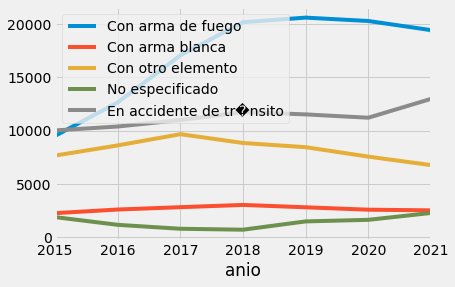

In [14]:
types = mrdr_all.Modalidad.unique()
types_mrdrs = pd.DataFrame()
for mrdr,year in zip(types,years):
    dF = mrdr_all[mrdr_all["Modalidad"]== mrdr].groupby('anio').sum()
    types_mrdrs[mrdr] = dF['all']

types_mrdrs.plot(y=types,xlim = (2015,2021))

From the figure, it can be appreciated that murders with fire arms have been the predominant way of murder in Mexico from 2015 to 2021. The values from 2022 are incomplete so we can't have a good comparison at the moment. We'll discuss the ongoing figures later in this notebook.

In [15]:
mrdr_gun = mrdr_all[mrdr_all.Modalidad == "Con arma de fuego"].drop("Modalidad",axis=1).drop("Bien jur�dico afectado",axis=1)

In [16]:
mrdr_gun['all'] = [np.sum([mrdr_gun[col][i] for col in months]) for i in mrdr_gun.index]

(2015.0, 2021.0)

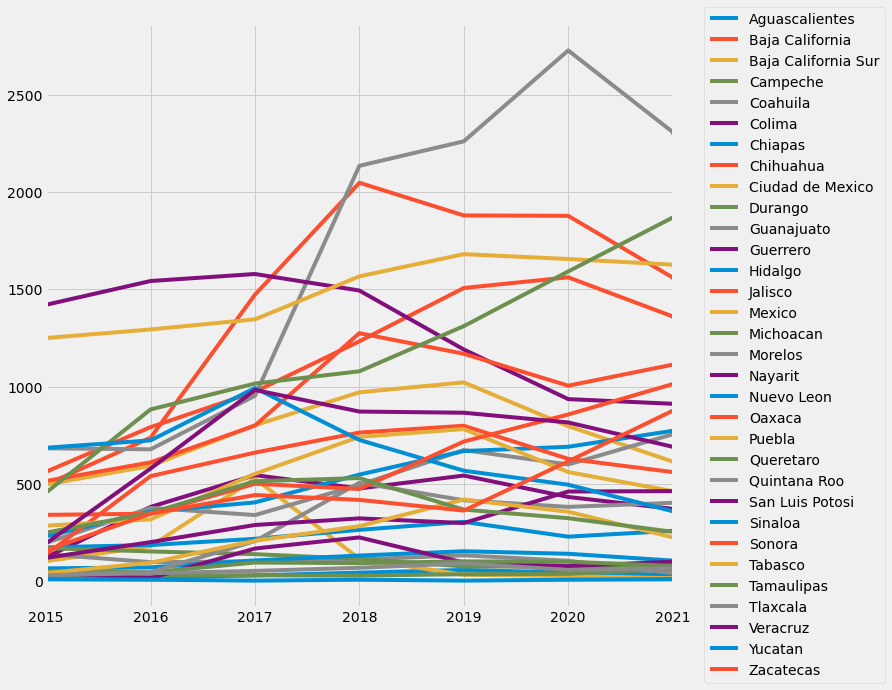

In [17]:
plt.figure(figsize=(10,10))
X = mrdr_gun['anio'].unique()
for state in mrdr_gun.Entidad.unique():
    
    y = [np.nan_to_num(mrdr_gun[(mrdr_gun['Entidad'] == state) & (mrdr_gun['anio'] == year) ]['all']).sum() for year in X]
    
    line = sns.lineplot(x = X,y = y,label = state)
line.legend(loc='right',bbox_to_anchor=(1.35,0.45))
line.set_xlim(2015,2021)


This is a rather messy. It would be more convenient to breakdown this figure and compare states which are closer to each other.

In [18]:
north = ["Sonora","Coahuila","Baja California", "Chihuahua","Tamaulipas","Nuevo Leon"]
north_west = ["Baja California Sur","Sinaloa","Durango","Nayarit","Zacatecas"]
centre_north = ["Jalisco","Aguascalientes","Colima","Michoacan","San Luis Potosi"]
centre = ["Guanajuato","Queretaro","Hidalgo","Mexico","Ciudad de Mexico","Morelos","Tlaxcala","Puebla"]
sur = ["Oaxaca","Chiapas","Veracruz","Tabasco","Campeche","Yucatan","Quintana Roo"]
mex_states = {"North":north,"North West":north_west,"Centre North":centre_north ,"Centre":centre,"South":sur}

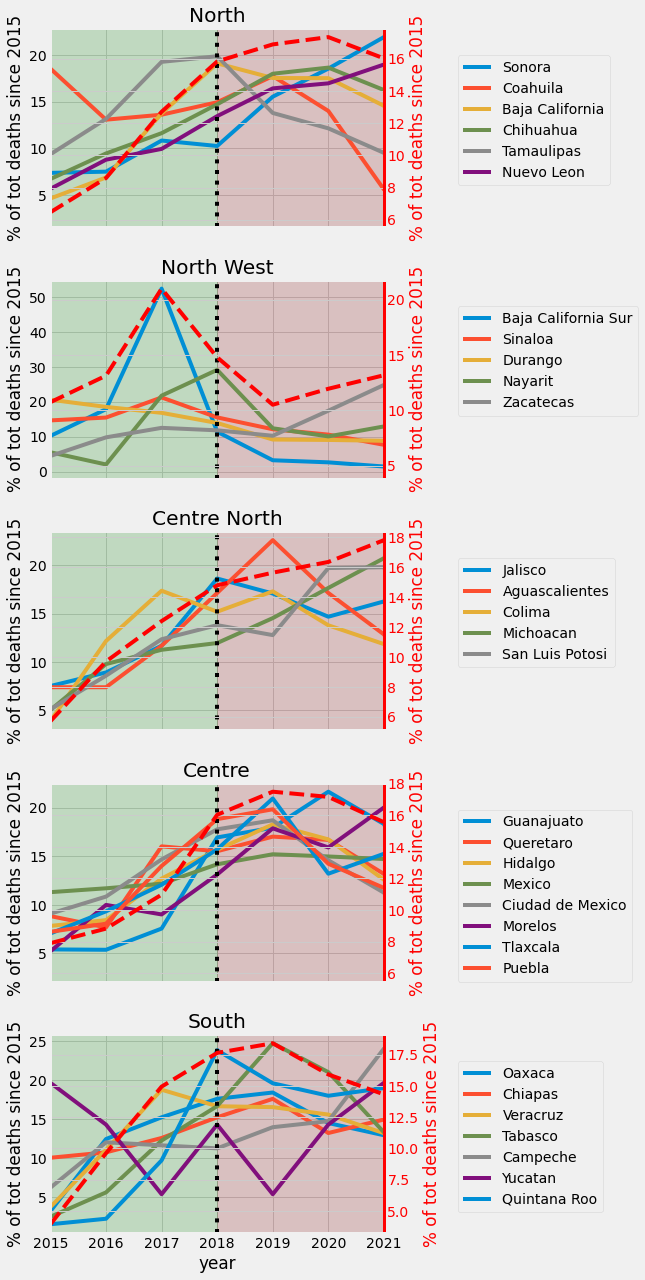

In [19]:
fig,ax = plt.subplots(5,1,figsize = (10,18),sharex = True)


for i,(region,states) in enumerate(mex_states.items()):
    
    for j,state in enumerate(states):
        y = np.array([mrdr_gun[(mrdr_gun['Entidad'] == state) & (mrdr_gun['anio'] == year) ]['all'].sum() for year in X])
        sns.lineplot(x = X,y = y/np.sum(y) * 100, ax = ax[i],label = state)
        
        if j == 0:
            all_states = np.array([y])
        else:
            all_states = np.concatenate([all_states,np.array([y])])

    if i == 0:
        all_gun_deaths = all_states
    else:
        all_gun_deaths = np.concatenate([all_gun_deaths,all_states])
    
    
    all_states = np.sum(all_states,axis=0)
    #print(all_states)
    axt = ax[i].twinx()
    sns.lineplot(x = X,y = all_states/np.sum(all_states)*100,ax=axt,linestyle = '--',color = 'r')
    axt.spines['right'].set_color('red')
    axt.tick_params(axis='y',color = 'r',labelcolor='r')
    axt.set_ylabel(f'% of tot deaths since 2015',color='r')

    ax[i].set_title(region)
    ax[i].legend(bbox_to_anchor = (1.2,0.9))
    ax[i].set_xlim(2015,2021)
    ax[i].set_ylabel(f'% of tot deaths since 2015')
    ax[i].axvline(2018,ls=':',c='k')
    ax[i].axvspan(2018,2022,color='maroon',alpha = 0.2)
    ax[i].axvspan(2015,2018,color='green',alpha = 0.2)
    
ax[-1].set_xlabel("year")
plt.tight_layout()

#fig.savefig('deaths_regions.png',dpi=300)

The figure above can clearly demonstrate which states are the ones having the largest quantity of gun related homicides as well as which regions are having more issues with them. The gun related death trend in each region seems to be dominated to the violence corresponding to a state in particular. There are some states in which the violence is increasing constantly (and seamingly linear) whilst some other's murder rate has slowed down. The background colour corresponds to a period with a different president denoted by the colour of their political party and divided by a dotted line.

In [20]:
temp = mrdr_gun.groupby('anio').sum()
coll_per_year = pd.DataFrame()
test2 = []

for year in temp.index:
    vals = [ temp[month][year] for month in temp.columns[-13:-1]]
    coll_per_year[year] = vals
    test2.append(vals)

cont_per_year = np.array(test2).flatten()
    

Text(0, 0.5, 'gun murders per month')

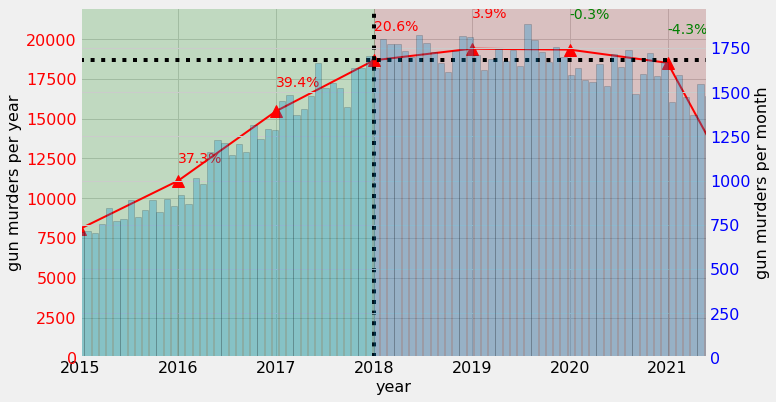

In [21]:
fontsize = 16
temp.columns[::-12]

pct_change = [all_gun_deaths.sum(axis=0)[i + 1]/all_gun_deaths.sum(axis=0)[i] *100 - 100 for i in range(len(all_gun_deaths.sum(axis=0)) - 2)]

T = np.linspace(2015,2022,len(cont_per_year))

fig,ax = plt.subplots(figsize=(10,6))
axt = ax.twinx()


ax.plot(X,all_gun_deaths.sum(axis=0),color='r',marker='^',markersize=12,linewidth = 2)
axt.bar(T,cont_per_year,alpha = 0.3,edgecolor='k',width=0.065)


ax.axvline(2018,ls=':',c='k')
ax.set_xlim(2015,2021.4)
ax.axvspan(2018,2022,color='maroon',alpha = 0.2)
ax.axvspan(2015,2018,color='green',alpha = 0.2)
ax.axhline(all_gun_deaths.sum(axis=0)[X == 2018],ls = ':',c='k')

for i,change in enumerate(pct_change):
    
    color = 'r'
    if change < 0:
        color='g'
    ax.text(X[i+1],all_gun_deaths.sum(axis=0)[i+1]*1.1,s=f'{np.round(change,1)}%',color=color)

ax.tick_params(axis = 'y',color='r',labelcolor='r')

ax.tick_params(labelsize=fontsize)
ax.set_ylim(0,22000)
ax.set_xlabel('year',fontsize=fontsize)
ax.set_ylabel('gun murders per year',fontsize=fontsize)
axt.tick_params(axis = 'y',color='b',labelcolor='b',labelsize=fontsize)
axt.set_ylabel('gun murders per month',fontsize=fontsize)

The murder rate has been observed to be decreasing since 2019. The total amount of murders has dropped by almost 5% from 2019 to 2021 and the murders per month seem to have a clear trend decrease. It is worth noticing that the murders have a larger variation from month to month since 2019.

The trend in gun related murders seems to be decreasing from 2018 since in 2021, it shows that the murders have been slightly less than in 2018, which is great news! Hopefully this trend can continue

# Map Visualization

This is work in progress. The map will highlight if a state has a positive or negative trend in murders.

In [22]:
mask = (mrdr_gun['Entidad'] == 'Aguascalientes') & (mrdr_gun['anio'] == 2021)
mrdr_gun[mask]['all']

18816    32.0
18820     1.0
Name: all, dtype: float64

In [23]:
change_17_18 = dict()
change_18_19 = dict()
change_19_20 = dict()
change_20_21 = dict()


for state in mrdr_all.Entidad.unique():
    mask21 = (mrdr_gun['Entidad'] == state) & (mrdr_gun['anio'] == 2020)
    mask20 = (mrdr_gun['Entidad'] == state) & (mrdr_gun['anio'] == 2021)
    mask19 = (mrdr_gun['Entidad'] == state) & (mrdr_gun['anio'] == 2019)
    mask18 = (mrdr_gun['Entidad'] == state) & (mrdr_gun['anio'] == 2018)
    mask17 = (mrdr_gun['Entidad'] == state) & (mrdr_gun['anio'] == 2017)

    y17 = mrdr_gun[mask17]['all'].sum()
    y18 = mrdr_gun[mask18]['all'].sum()
    y19 = mrdr_gun[mask19]['all'].sum()
    y20 = mrdr_gun[mask20]['all'].sum()
    y21 = mrdr_gun[mask21]['all'].sum()

    change_20_21[state] = np.round(y21/y20 *100 - 100,2)
    change_19_20[state] = np.round(y20/y19 *100 - 100,2)
    change_18_19[state] = np.round(y19/y18 *100 - 100,2)
    change_17_18[state] = np.round(y18/y17 *100 - 100,2)

In [24]:
import geopandas as gpd

In [25]:
states_gpd = gpd.read_file('mexstates/mexstates.shp')

In [26]:
states_gpd['ADMIN_NAME'].replace('Distrito Federal','Ciudad de Mexico',inplace=True)

In [27]:
states_gpd = states_gpd.sort_values('ADMIN_NAME')

In [28]:
states_gpd['change_20_21'] = change_20_21.values()
states_gpd['change_19_20'] = change_19_20.values()
states_gpd['change_18_19'] = change_18_19.values()
states_gpd['change_17_18'] = change_17_18.values()

In [29]:
states_gpd.columns[-4:]

Index(['change_20_21', 'change_19_20', 'change_18_19', 'change_17_18'], dtype='object')

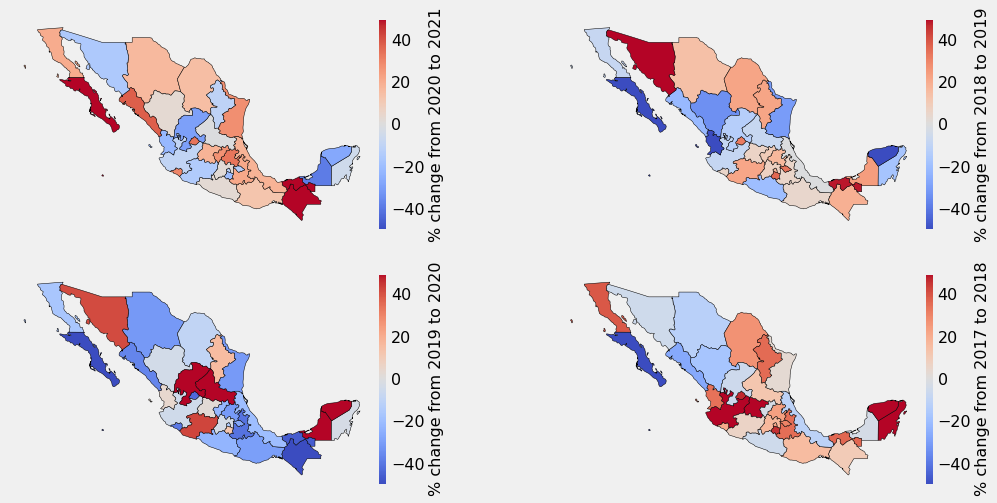

In [30]:

fig,ax = plt.subplots(2,2,figsize=(16,8))

j = 0
for i,key in enumerate(states_gpd.columns[-4:]):

    if i > 1:
        i -= 2
        j = 1

    vmin,vmax = -50,50

    cm = plt.cm.ScalarMappable(cmap = 'coolwarm',norm = plt.Normalize(vmin=vmin,vmax=vmax))

    im1 = states_gpd.plot(column = key,ax=ax[i,j],cmap = 'coolwarm',norm = plt.Normalize(vmin=vmin,vmax=vmax),
                            edgecolor='k')
    cbar = fig.colorbar(cm,ax=ax[i,j],pad = 0)

    text_cbar = f"% {key.split('_')[0]} from 20{key.split('_')[1]} to 20{key.split('_')[-1]}"
    cbar.set_label(text_cbar,fontsize = fontsize)
    cbar.ax.tick_params(labelsize=fontsize)
    ax[i,j].axis('off')
    



The figure on top is quite interesting. It demonstrates how gun related murders have changed through the years. 

# Deeper analysis

As an preliminary step, I'll add new features to the *total* amount of murders per country, mexican president, american president, covid, (gdp?), and unemployment rates.

In [54]:
anios = mrdr_gun.anio.unique()
meses = mrdr_gun.columns[-13:-1]
dates = []

for anio in anios:
    for i,mes in enumerate(meses):
        if i+1 < 10:
            i = f'0{i+1}'    
            dates.append(f'{anio}-{i}' )
        else:
            dates.append(f'{anio}-{i+1}' )
dates = pd.to_datetime(dates)

In [268]:
temp_df = mrdr_gun.groupby('anio').sum()

values = []
for year in temp_df.index:
    for month in temp_df.columns[-13:-1]:
        values.append(temp_df[month].loc[temp_df.index == year].values[0])

In [269]:
all_murders = pd.DataFrame(index=dates)
all_murders['murders'] = values

In [270]:
# read and extract information and prepare to feed into a new DataFrame
gdp_growth = pd.read_csv('gdp_growth/gdp_growth.csv')
gdp_current = pd.read_csv('gdp_current/gdp_current.csv')

gdp_growth = gdp_growth[gdp_growth['Country Name'] == 'Mexico']
gdp_current = gdp_current[gdp_current['Country Name'] == 'Mexico']

gdp_growth_values = [gdp_growth[year].values[0] for year in gdp_growth.columns[-61:] if int(year) > 2015]
gdp_current_values = [gdp_current[year].values[0] for year in gdp_current.columns[-61:] if int(year) > 2015]

gdp_growth_values.append(gdp_growth_values[-1])
gdp_current_values.append(gdp_current_values[-1])

In [271]:
#unemployment rates
unempl_rates = pd.read_csv('unemployment_rates.csv')

In [272]:
unempl_rates = unempl_rates[unempl_rates.LOCATION == 'MEX']
unempl_rates['TIME'] = pd.to_datetime(unempl_rates['TIME'])
unempl_rates = unempl_rates[unempl_rates['TIME'] > "2015-01-01"]
unemp = unempl_rates['Value'].values

In [277]:
def add_features(df,gdp_g,gdp_c,unemp):
    df = df.copy()
    df['year'] = df.index.year
    df['mexican president'] = np.zeros(len(all_murders.murders))
    df['mexican president'].loc[df.index > "2018-01-01"] = 1
    df['american president'] = np.zeros(len(all_murders.murders))
    df['american president'].loc[(df.index > "2017-01-01") & (df.index < "2021-01-01")] = 1
    df['american president'].loc[df.index > "2021-01-01"] = 2

    
    df['unemployment rate'] = unemp

    df['gdp growth'] = np.zeros(len(all_murders.murders))
    df['gdp current'] = np.zeros(len(all_murders.murders))
    for year,growth,actual in zip(df.year.unique(),gdp_g,gdp_c):
        df['gdp growth'][df['year'] == year] = growth
        df['gdp current'][df['year'] == year] = actual

    return df



In [278]:
def pad_to_fit(x,df):
    diff = len(df.index) - len(x)
    pad = np.zeros(diff)
    return np.append(x,pad)

unemp = pad_to_fit(unemp,all_murders)    

In [279]:
all_murders = add_features(all_murders,gdp_growth_values,gdp_current_values,unemp)

/home/lucas/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/lucas/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lucas/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

<AxesSubplot:>

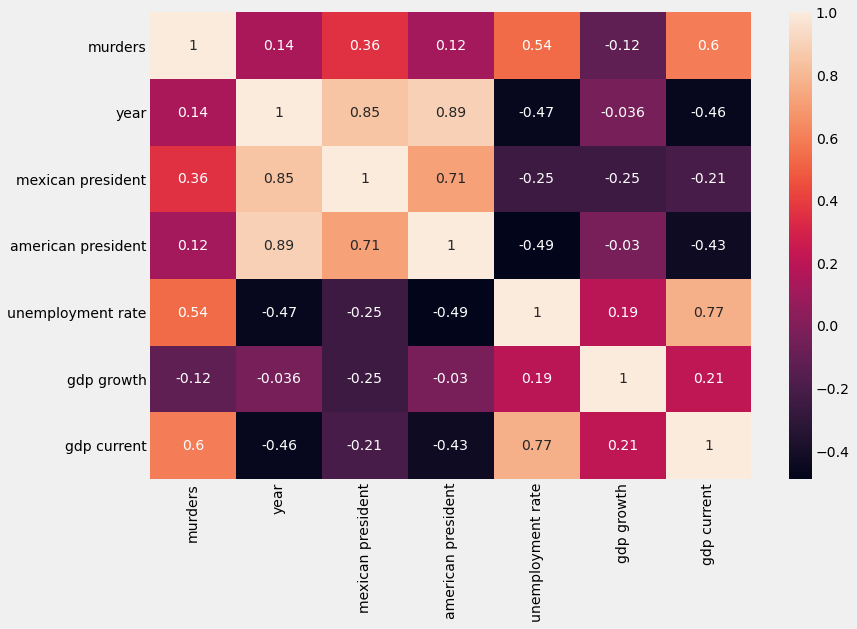

In [280]:
fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(all_murders.corr(),annot=True,ax=ax)

This figure is quite interesting. It can demonstrate that there is some correlation between current gdp, the change in president, the unemployment and the murders.

# Forecast

It is of interest regarding the data that we have to see if we can fit a machine learning model to forecast the gun murders of the country

In [297]:
train = all_murders.loc[all_murders.index <"2020-01-01"]
test = all_murders.loc[(all_murders.index >="2020-01-01") & (all_murders.index < "2022-05-01")]

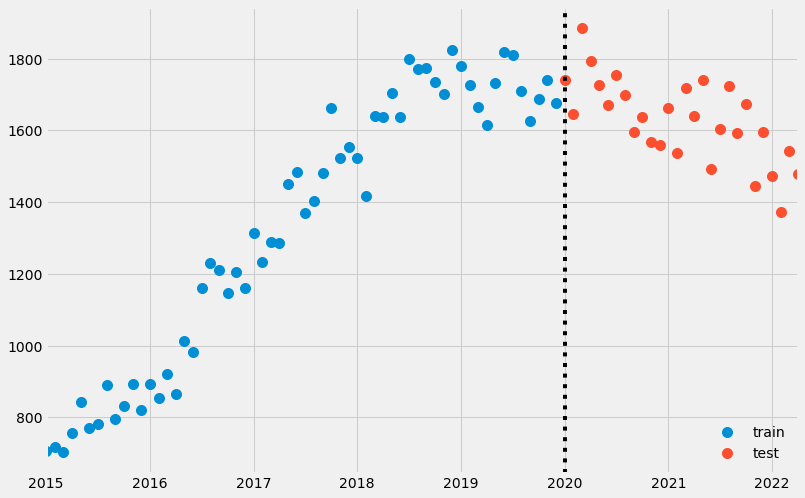

In [301]:
fig,ax = plt.subplots(figsize=(12,8))
train.plot(y = 'murders',style='.',ax=ax,label='train',markersize=20)
test.plot(y = 'murders',style='.',ax=ax,label='test',markersize=20)
ax.axvline('2020-01-01',ls=':',c='k')
ax.legend(loc='lower right',frameon=False)

In [304]:
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

First, we need to scale the GDP sincer it is a rather large number compared to everything else. 

In [313]:
scaler = StandardScaler()
train['gdp current'] = scaler.fit_transform(train[['gdp current']])
test['gdp current']= scaler.fit_transform(test[['gdp current']])

/home/lucas/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/lucas/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [315]:
train.columns

Index(['murders', 'year', 'mexican president', 'american president',
       'unemployment rate', 'gdp growth', 'gdp current'],
      dtype='object')

In [316]:
FEATURES = ['year', 'mexican president', 'american president',
       'unemployment rate', 'gdp growth', 'gdp current']
TARGET = ['murders']

In [317]:
x_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET]

In [321]:
xgb_reg = XGBRegressor(n_estimators = 500,n_jobs = 6,early_stopping=25)

xgb_reg.fit(x_train,y_train,eval_set = [(x_train,y_train),(x_test,y_test)],verbose=True)
predictions = xgb_reg.predict(x_test)

[14:23:08] WARNING: ../src/learner.cc:573: 
Parameters: { "early_stopping" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:988.12909	validation_1-rmse:1164.04724
[1]	validation_0-rmse:709.65015	validation_1-rmse:836.72748
[2]	validation_0-rmse:510.12250	validation_1-rmse:582.57477
[3]	validation_0-rmse:368.92108	validation_1-rmse:402.65485
[4]	validation_0-rmse:269.74234	validation_1-rmse:304.66138
[5]	validation_0-rmse:201.65257	validation_1-rmse:266.83206
[6]	validation_0-rmse:154.61183	validation_1-rmse:211.30156
[7]	validation_0-rmse:121.89785	validation_1-rmse:189.37073
[8]	validation_0-rmse:97.51295	validation_1-rmse:165.85396
[9]	validation_0-rmse:79.74498	validation_1-rmse:162.99272
[10]	validation_0-rmse:67.54090	validation_1-rmse:167.86269
[11]	

/home/lucas/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [323]:
test['predictions'] = predictions

/home/lucas/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


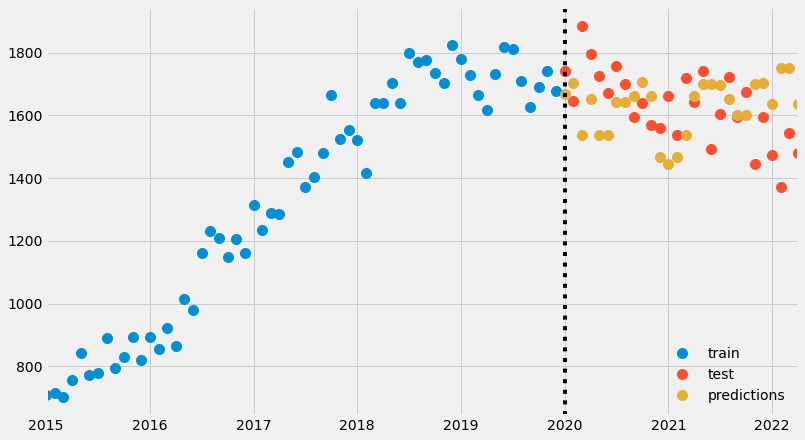

In [326]:
fig,ax = plt.subplots(figsize=(12,7))

train.plot(y = 'murders',style='.',ax=ax,label='train',markersize=20)
test.plot(y = 'murders',style='.',ax=ax,label='test',markersize=20)
test.plot(y = 'predictions',style='.',ax=ax,label='predictions',markersize=20)
ax.axvline('2020-01-01',ls=':',c='k')
ax.legend(loc='lower right',frameon=False)